 # PROJET 3: MODELISATION DU RISQUE DU CREDIT( MODELE DE SCORING)  #

# Compréhension du problème

Lorsqu'une banque prête de l'argent à une personne, elle prend le risque que cette dernière ne rembourse pas cet argent dans le délai convenu.Ce risque est appelé rsique de crédit.Alors avant d'octroyer un crédit , les banques vérifient si le client(ou la cliente) qui demandent un prêt sera capable ou pas de le rembourser.Cette vérification se fait grace à l'analyser de plusieurs paramètres tels que les revenus, les biens, les dépenses actuelles du client, etc. Cette analyse est effectuée manuellement par plusieurs banques.Ainsi, elle est très consommatrice en temps et en ressources finacières.

Grâce au Machine Learning, il est possible d'automatiser cette tâche. Dans ce projet nous allons construire un algorithme capable de prédire si une personne sera en défaut de paiement ou pas (1: défaut, 0: non défaut).Nous sommes donc face à un problème de classification car nous voulons prédire un variable discrète( binaire pour être précis).

# LIBRAIRIES

In [4]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

DONNEES

Deux types de données peuvent être utilisés pour modéliser la probalité de défaut de payment: 
    1- Données liées à la demande de crédit;
    2- Données comportementales décrivant le bénéficiare du prêt.
    
Dans la pratique , les banques utilisent un mélange de ces deux types de données pour construire leur modèle de scoring appliqué au risque de crédit.

Commencons par l'importation des données:


In [3]:
df=pd.read_csv("https://github.com/JosueAfouda/Credit-Risk-Modeling/raw/master/data_credit.txt")

df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


L' ensemble des données comporte 12 variables et 32581 OBSERVATIONS (lignes) historiques. Chaque observation correspond à une personne ayant contracté un prêt.On a des variables qui décrivent le crédit(montant, statut, taux d'intérêt, etc.) et d'autres variables qui décrivent la personne ayant contracté ce crédit(âge, revenu, etc.).Nous allons donc utiliser ces données historiques afin de construire le modèle de scoring qui va prédire le statut des nouveaux candidats à un crédit.

Il est très important de comprendre  les variables de notre jeu de données:




0   person_age : Variable indiquant l'âge de la personne.                
1   person_income : Variable indiquant les revenus (ou encore le salaire) de la personne.               
2   person_home_ownership : Variable indiquant le statut de la personne par rapport à son lieu d'habitation(propriétaire, locataire,etc).      
3   person_emp_length : Variable indiquant la durée (du mois) depuis laquelle la personne est en activité professionnelle.           
4   loan_intent : Variable indiquant le motif du credit                  
5   loan_grade : Variable indiquant le grade du prêt.                 
6   loan_amnt  : Variable indiquant le motant du prêt.                   
7   loan_int_rate : Variable indiquant le taux d'intérêt du crédit.              
8   loan_status : C'est la variable d'intérêt. Elle indique si la personne est en défaut de paiement (1) ou pas(0).                
9   loan_percent_income : Variable indiquant le pourcentage des revenus par rapport au crédit.     
10  cb_person_default_on_file : Variable indiquant si la personne est à découvert ou pas.
11  cb_person_cred_hist_length : Variable indiquant la durée des antécédents de crédits.



Passons à présent l'analyse exploiratoire des données qui nous permettra de mieux les comprendre.


# ANALYSE EXPLORATOIRE DES DONNEES

In [8]:
# Résumé statistique des donnéees

df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


Nous remarquons que les moyennes et les écart-types sont très différentes d'une variable à une autre. Celà indique que les donées ne sont pas à la même échelle. Selon l'algorithme que nous utiliserons , il faudra absolument normaliser les données avant de les modéliser.En effet, certains algorithme de Machine Learning nécessite une normalisation des données pour un meilleur résultat.

Une manière très rapide de visualiser les distributions des variables ainsi que les nuages de points est d'utiliser la fonction pairplot() de seaborn:

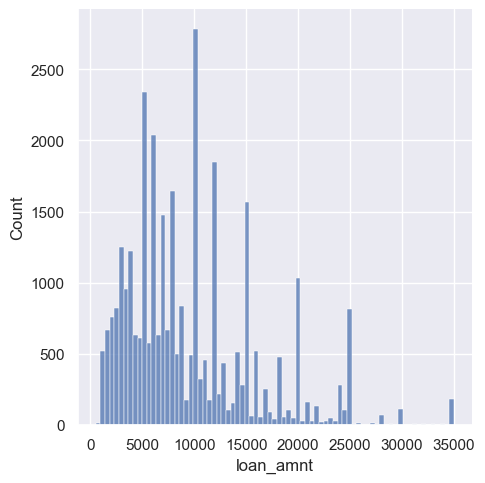

In [10]:
# Distribution de la variable "loan_amnt"
sns.set(rc={"figure.figsize": (12,8)})

sns.displot(df["loan_amnt"])

plt.show()

In [13]:
# Coefficient d'assymétrie
df.skew()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13792\4078175080.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew()


person_age                     2.581393
person_income                 32.865349
person_emp_length              2.614455
loan_amnt                      1.192477
loan_int_rate                  0.208550
loan_status                    1.364888
loan_percent_income            1.064669
cb_person_cred_hist_length     1.661790
dtype: float64

le coefficient de la variable person_income est très élevé.Pour corriger cela, faisons une transformation logarithmique de cette variable:



In [14]:
# transformation log de la variable "person_income"

df["person_income"]=np.log(df["person_income"])

In [15]:
# Coefficient d'assymétrie de la  variable transformée

df["person_income"].skew()

0.1559408016162584

In [ ]:
waouh!

In [ ]:
Tracons à présent le nuage de points des revenus en fonction en de l'age

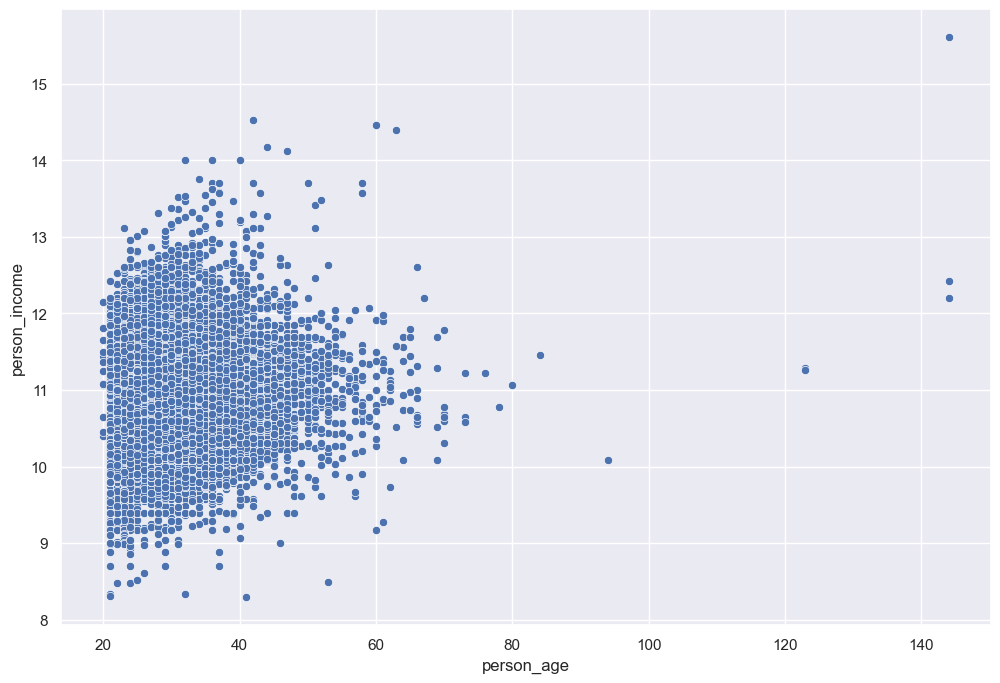

In [17]:
# Pour tracer un nuage de points

sns.set(rc={"figure.figsize": (12,8)})

sns.scatterplot(x="person_age", y="person_income",  data=df) # revenus en fonction de l'âge

plt.show()

Le graphique ci dessus , nous montre qu'il y'a une très faible corrélation positive  entre les revenus et l'âge.Nous remarquons aussi des outliers
( ce sont les valeurs abbérantes, c'est- à -dire les valeurs qui sortent du lot).
 
Analysons à présent la fréquence des modalités de chaque variable catégorielle: 

#### Inspection de la dataframe df

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  float64
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 3.0+ MB


In [ ]:
0 person_age : Variable indiquant l'âge de la personne.
1 person_income : Variable indiquant les revenus (ou encore le salaire) de la personne.
2 person_home_ownership : Variable indiquant le statut de la personne par rapport à son lieu d'habitation(propriétaire, locataire,etc).
3 person_emp_length : Variable indiquant la durée (du mois) depuis laquelle la personne est en activité professionnelle.
4 loan_intent : Variable indiquant le motif du credit
5 loan_grade : Variable indiquant le grade du prêt.
6 loan_amnt : Variable indiquant le motant du prêt.
7 loan_int_rate : Variable indiquant le taux d'intérêt du crédit.
8 loan_status : C'est la variable d'intérêt. Elle indique si la personne est en défaut de paiement (1) ou pas(0).
9 loan_percent_income : Variable indiquant le pourcentage des revenus par rapport au crédit.
10 cb_person_default_on_file : Variable indiquant si la personne est à découvert ou pas. 
11 cb_person_cred_hist_length : Variable indiquant la durée des antécédents de crédits.

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


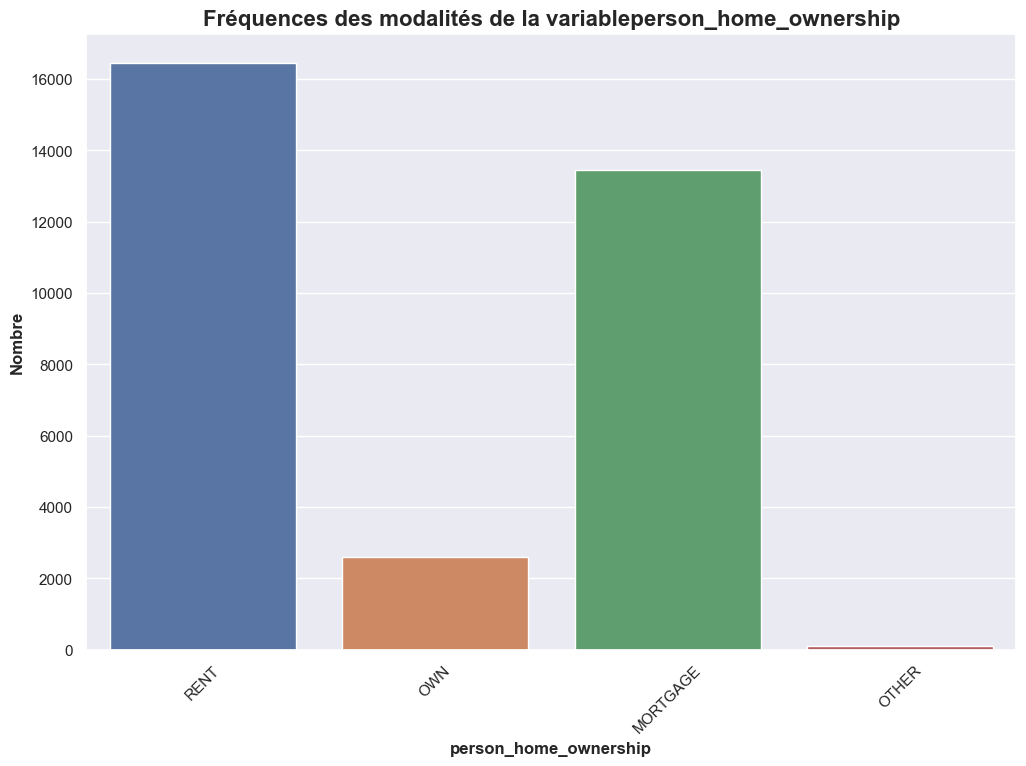

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


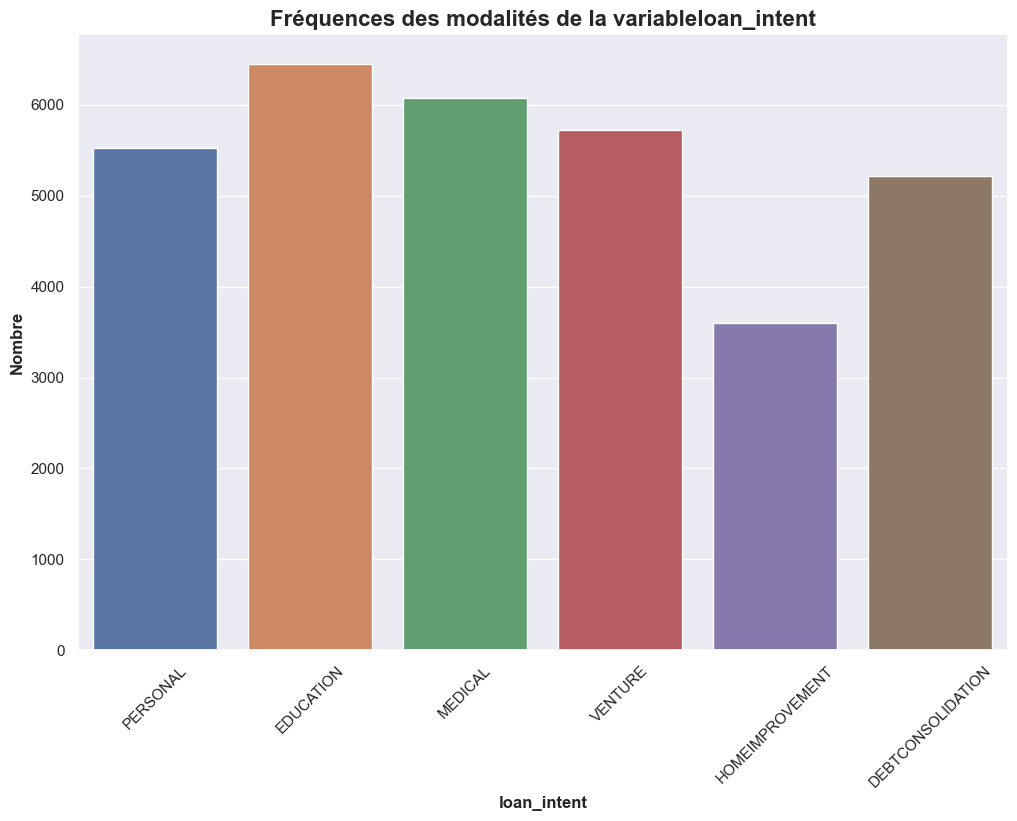

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


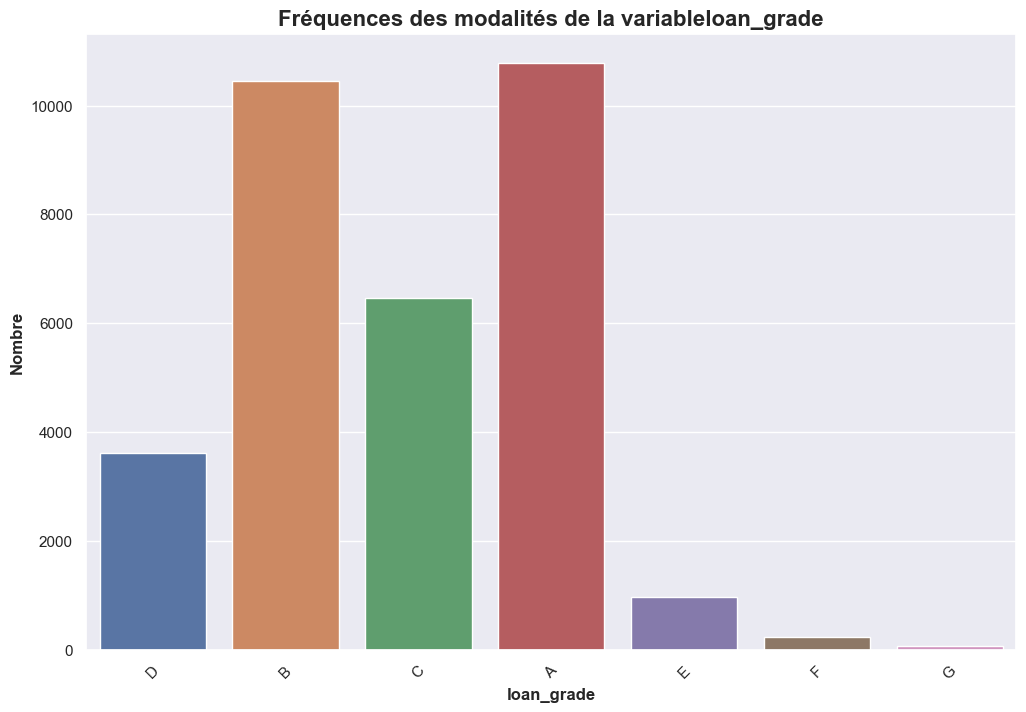

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


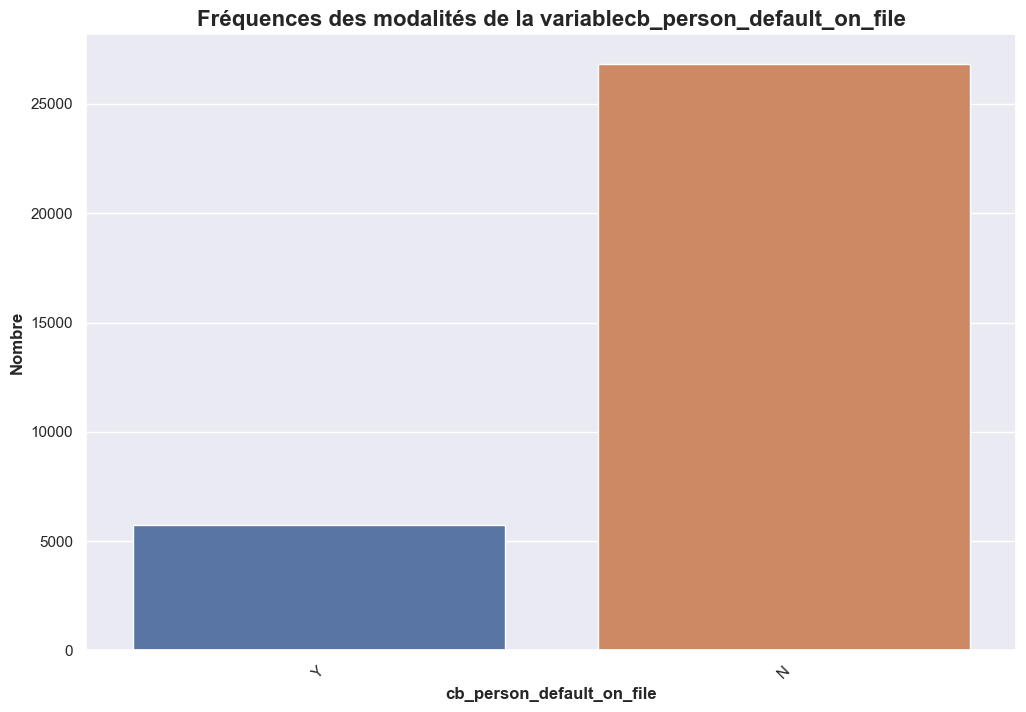

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


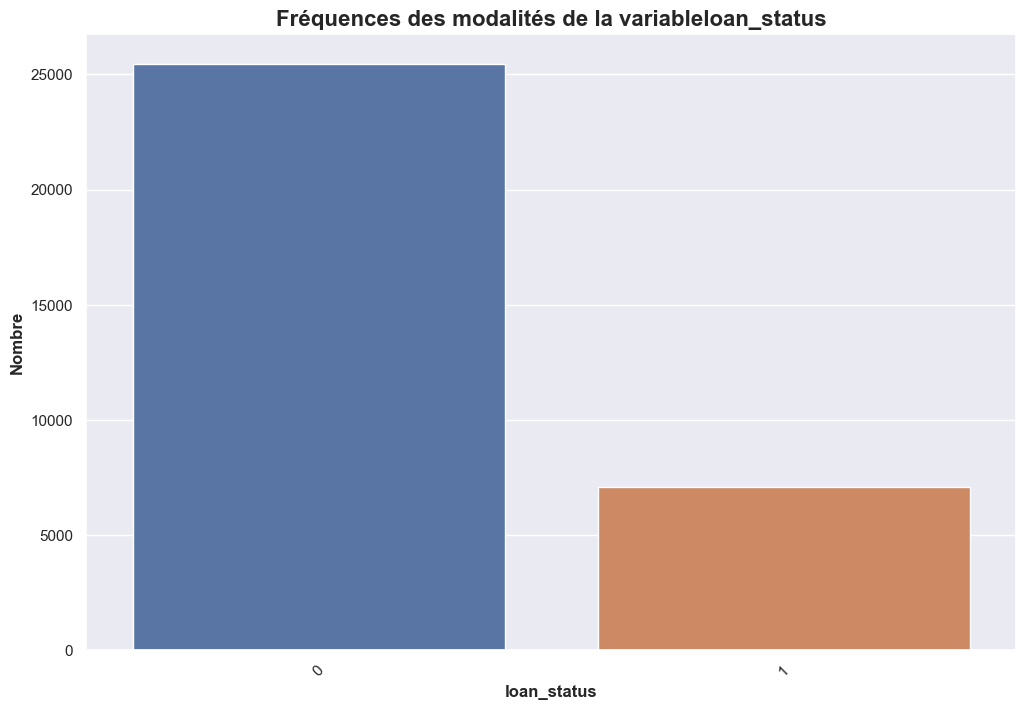

In [23]:
# Faisons une boucle for pour construire un diagramme à barre pour toutes les variables qualitatives


for col in df.select_dtypes(include=["object"]).columns.to_list() + ["loan_status"]:
    sns.countplot(df[col])
    
    plt.xlabel(col, fontweight="bold")
    
    plt.ylabel("Nombre", fontweight="bold")
    
    plt.xticks(rotation= 45)
    
    plt.title("Fréquences des modalités de la variable" + str(col), fontsize=16, fontweight="bold")
    
    plt.show()
    
    print("\n");


Nous remarquons un déséquilibre de classe au niveau de la variable cible ou d'intérêt(loan_statut).
Il y'a beaucoup plus de personnes qui n'ont pas été en défaut de paiement.Ce problème peut impacter la qualité de notre modèle car ce dernier pourrait avoir tendance à prédire que tous les nouveaux demandeurs de prêts ne seront pas en défaut de paiement.Ceci causerait d'énormes êrtes d'argent à la banque . Il existe plusieurs méthodes pour traiter le problème de déséquilibre de classe.Nous utiliserons l'une de ces méthodes dans la partie prétraitement des données avant la modélisation.


Très souvent, les données financières sont souvent analysées avec des tableaux croisés dynamiques comme dans Excell.Construisons alors quelques tableaux croisés dynamiques:

In [24]:
# tableau croisées dynamiques entre le motif de prêt et le statut du prêt

pd.crosstab(df["loan_intent"], df["loan_status"], margins=True)


loan_status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,3722,1490,5212
EDUCATION,5342,1111,6453
HOMEIMPROVEMENT,2664,941,3605
MEDICAL,4450,1621,6071
PERSONAL,4423,1098,5521
VENTURE,4872,847,5719
All,25473,7108,32581


In [26]:
# Tableau croisées dynamiques de l'accès à la propriété groupé par le statut ainsi que le grade du crédit

pd.crosstab(df["person_home_ownership"], [df["loan_status"], df["loan_grade"]])

loan_status               0                                 1             \
loan_grade                A     B     C    D    E   F  G    A     B    C   
person_home_ownership                                                      
MORTGAGE               5219  3729  1934  658  178  36  0  239   324  321   
OTHER                    23    29    11    9    2   0  0    3     5    6   
OWN                     860   770   464  264   26   7  0   66    34   31   
RENT                   3602  4222  2710  554  137  28  1  765  1338  981   

loan_status                               
loan_grade                D    E   F   G  
person_home_ownership                     
MORTGAGE                553  161  61  31  
OTHER                    11    6   2   0  
OWN                      18   31   8   5  
RENT                   1559  423  99  27

In [29]:
# Tableau croisées dynamiques du % en moyen du revenu par rapport au montant du prêt groupé par les variables "person_home_ownership" et "loan_status"

pd.crosstab(df["person_home_ownership"], df["loan_status"], values=df["loan_percent_income"], aggfunc="mean")

loan_status,0,1
person_home_ownership,,
MORTGAGE,0.146504,0.184882
OTHER,0.143784,0.300000
OWN,0.180013,0.297358
RENT,0.144611,0.264859


In [ ]:
9 loan_percent_income : Variable indiquant le pourcentage des revenus par rapport au crédit.


par exemple, le revenu de ceux qui ont leur propre maison(donc les propriétaires) et qui sont en défaut de paiement est égal en moyenne à 29,73% 
du montant de leur crédit.

Quelle est la relation entre le pourcentage du revenu et le statut du crédit?

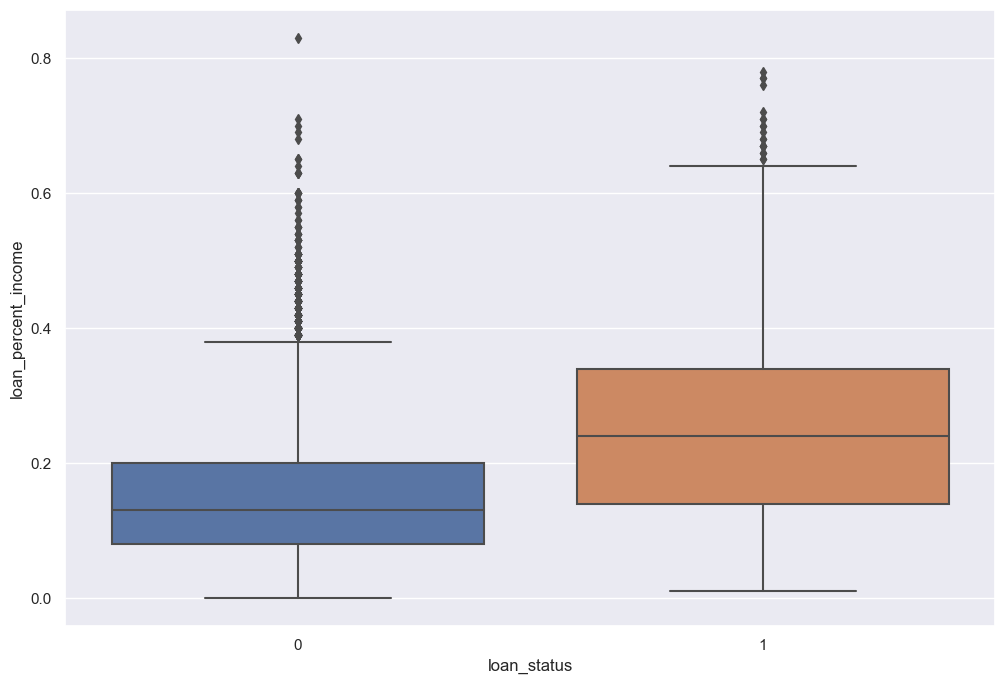

In [31]:
# loan_status vs loan_percent_income
sns.boxplot(x="loan_status", y="loan_percent_income", data=df)

plt.show()

8 loan_status : C'est la variable d'intérêt. Elle indique si la personne est en défaut de paiement (1) ou pas(0).

Selon ce graphique, le pourcentage moyen de revenu(par rapport au montant du prêt) pour les personnes en défaut de paiementest plus élévés.Cela indique 
que ces bénéficiaires ont un ratio dette/revenu déjà trop élevé.En effet, lorsque le ratio dette/ revenu est très important, cela veut simplement que le 
crédit est trop élevé par rapport aux revenus de la personne.Et lorsqu'on a un crédit trop élevé par rapport à ses revenus, 
le risque d'être en défaut de paiement est logiquement et naturellement élevé.

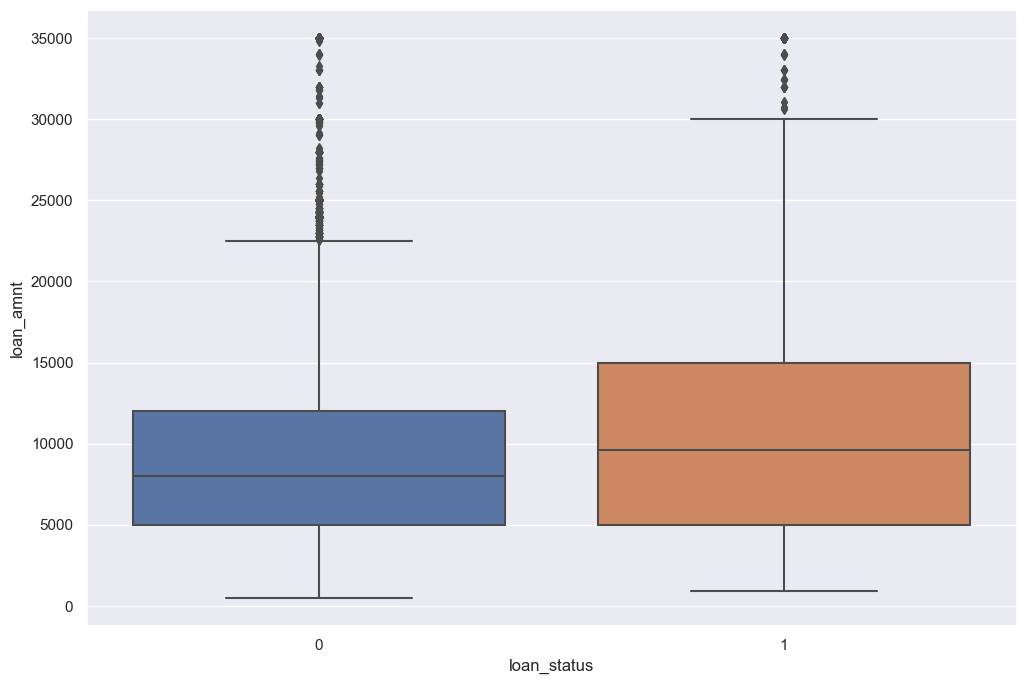

In [32]:
# loan_status vs loan_amnt
sns.boxplot(x="loan_status", y="loan_amnt", data=df)

plt.show()

In [ ]:
Liste descriptives des variables


0 person_age : Variable indiquant l'âge de la personne.
1 person_income : Variable indiquant les revenus (ou encore le salaire) de la personne.
2 person_home_ownership : Variable indiquant le statut de la personne par rapport à son lieu d'habitation(propriétaire, locataire,etc).
3 person_emp_length : Variable indiquant la durée (du mois) depuis laquelle la personne est en activité professionnelle.
4 loan_intent : Variable indiquant le motif du credit
5 loan_grade : Variable indiquant le grade du prêt.
6 loan_amnt : Variable indiquant le motant du prêt.
7 loan_int_rate : Variable indiquant le taux d'intérêt du crédit.
8 loan_status : C'est la variable d'intérêt. Elle indique si la personne est en défaut de paiement (1) ou pas(0).
9 loan_percent_income : Variable indiquant le pourcentage des revenus par rapport au crédit.
10 cb_person_default_on_file : Variable indiquant si la personne est à découvert ou pas. 
11 cb_person_cred_hist_length : Variable indiquant la durée des antécédents de crédits.

In [ ]:
Globalement, Les personnes en défaut de paiement ont un crédit supérieur à celui des personnes qui ont remboursé leurs prêts.

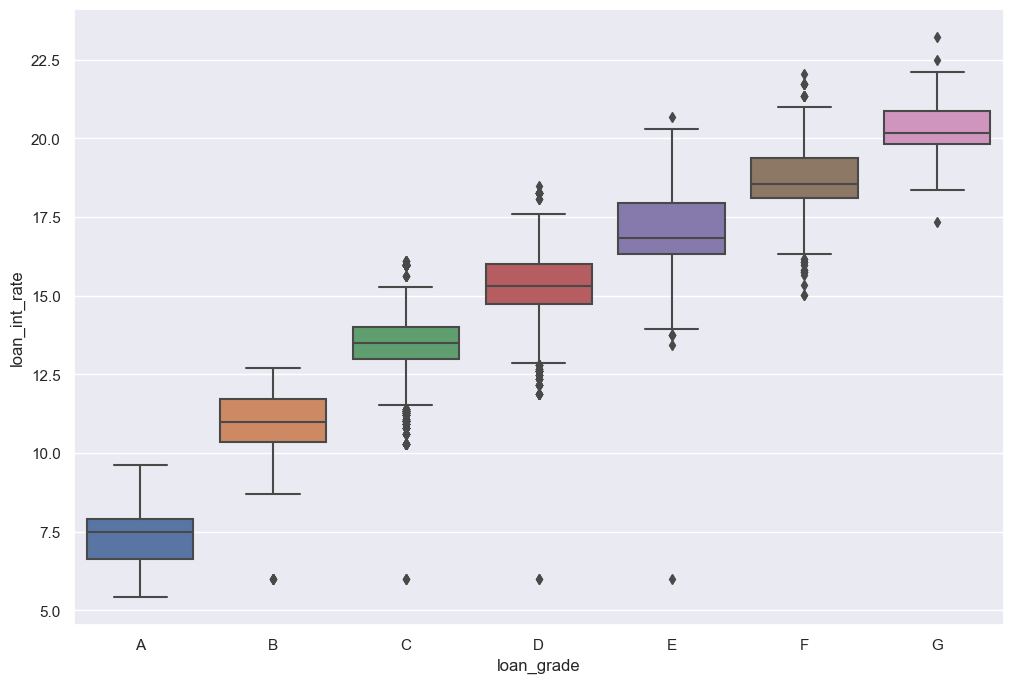

In [36]:
# loan_int_rate vs loan_grade

credit_grade=["A", "B", "C", "D", "E", "F", "G"]

sns.set(rc={"figure.figsize": (12, 8)})

sns.boxplot(x="loan_grade", y="loan_int_rate",  data=df, order= credit_grade) 

plt.show()

In [ ]:
Plus le crédit est important( grade élevé), plus le taux d'intérêt est élevé.

In [ ]:
Construisons le même graphique sans outliers pour voir si on a les mêmes tendances

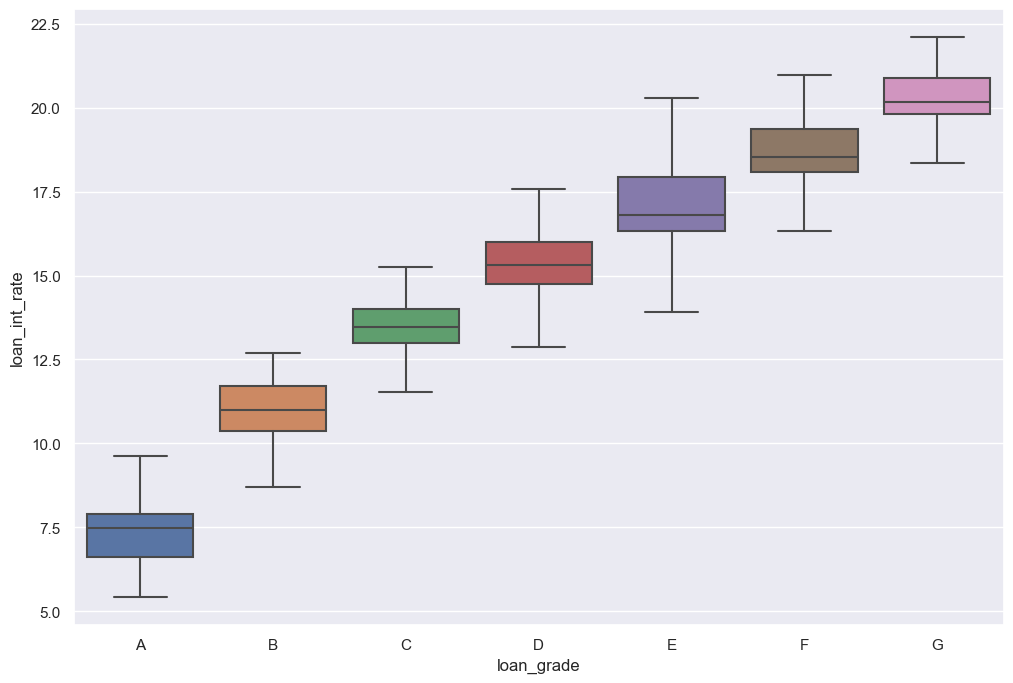

In [37]:
# Même graphique sans les outliers

sns.set(rc={"figure.figsize": (12, 8)})

sns.boxplot(x="loan_grade", y="loan_int_rate", sym="",  data=df, order= credit_grade) 

plt.show()



# CORRELATIONS

In [ ]:
# Cartes de corrélations

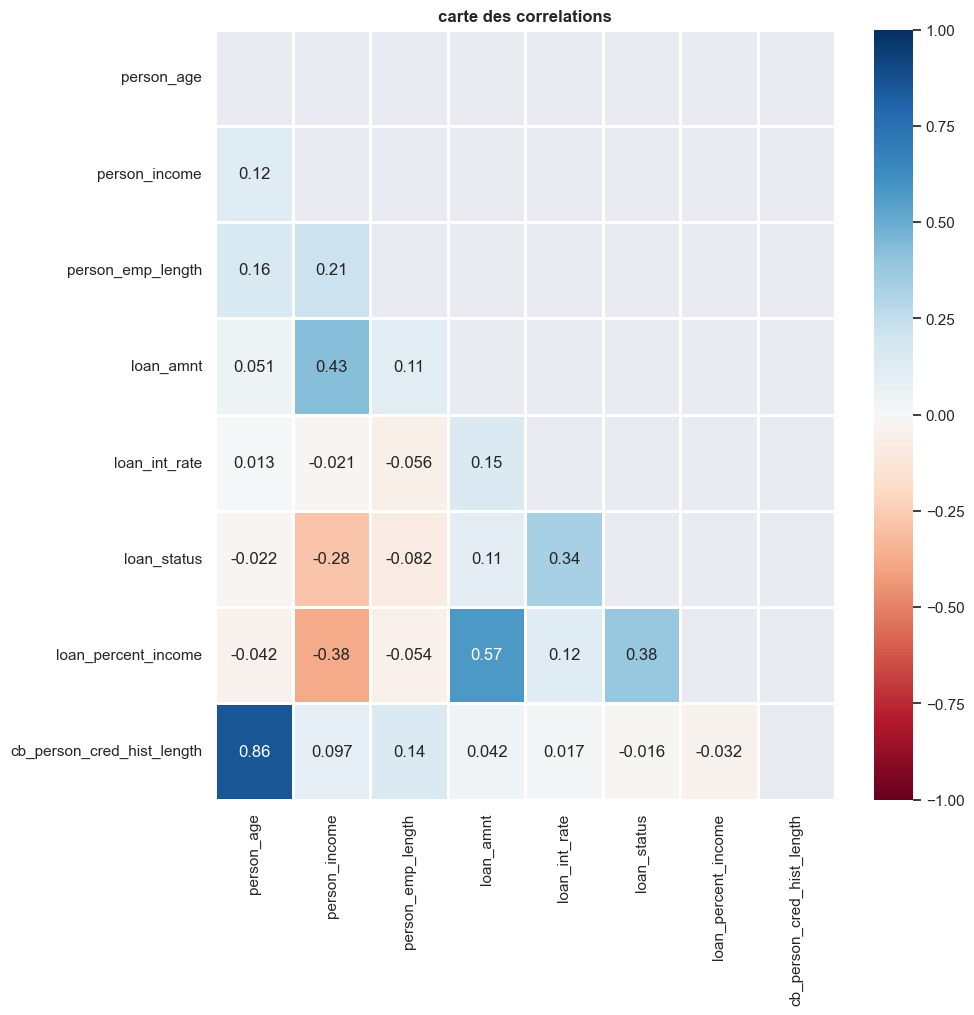

In [41]:
sns.set(rc={"figure.figsize": (10,10)})

mask=np.triu(np.ones_like(df.select_dtypes(exclude=["object"]).corr(), dtype=bool))

sns.heatmap(df.select_dtypes(exclude=["object"]).corr(),mask=mask, center=0, cmap='RdBu', linewidths=1, annot=True, fmt=".2", vmin=-1, vmax=1)

plt.title("carte des correlations",  fontweight="bold")

plt.show()

# NETTOYAGES DES DONNEES

Lors de l'analyse exploratoire des données ,nous avons remarqué la présence des outliers.Ces valeurs abbérantes peuvent affecter la qualité d'un modèle de machine Learning.Nous allons donc les retirer des données.

Avant de retirer les outliers, il faut d'abord les détecter.L'analyse exploratoire des données nous a permis de savoir que cette banque avait des clients de plus de 100 ans, même de plus de 140 ans.Nous pouvons utiliser le bon sens pour dire qu'il est très probable qu'une personne qui demande un crédit ait plus de 100 ans.Ainsi on supprimerait toutes les lignes où la variable person_age à des valeurs supérieurs à 100.

Il existe aussi desméthodes  statistiques, plus ou moins rigoureuses, pour détecter les outliers.Nous utiliserons l'une de ces méthodes à savoir l'inter-quartile.

# Méthode de détection des valeurs aberrantes basée sur l'inter-quartile(IQR)

Selon cette méthode, une valeur est abérrante si elle est inférieur à Q1-1.5IQR ou supérieure à Q3+1.5IQR.A partir de cette définition
créons une définition de détection des outliers.

In [44]:
def detection_outliers_by_iqr(y):
    
    Q1, Q3= np.quantile(y, 0.25),  np.quantile(y, 0.75)
    
    iqr= Q3 - Q1
    
    borne_inf= Q1 - iqr*1.5
    
    borne_sup= Q3 + iqr*1.5
    
    return np.where((y > borne_sup) | (y<borne_inf))
    
    

# SUPPRESSION DES OUTLIERS

In [45]:
# Application de la fonction detection_outliers_by_iqr()

indices_outliers_age = detection_outliers_by_iqr(df["person_age"])

print(indices_outliers_age)

print(type(indices_outliers_age))

(array([   81,   183,   575, ..., 32578, 32579, 32580], dtype=int64),)
<class 'tuple'>


Nous avons un tuple contenant un tableau numpy donnant les indices de lignes des valeurs aberrantes de la variable person_age
détectées par la fonction detection_outliers_by_iqr() précédemment créée.Nous allons supprimer ces observations(lignes):

In [46]:
df.drop(indices_outliers_age[0], inplace=True) # Le tableau numpy est le premier élément du tuple(donc d'indice 0)



In [47]:
df.shape

(31087, 12)

En supprimant les outliers, l'ensemble des données est passé de 32580 à 31087 observations.

# LES VALEURS MANQUANTES

In [48]:
# Nombre de valeurs manquantes

df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              861
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2953
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Il existe deux principales techniques pour traiter les valeurs manquantes:

1- Suppression des lignes contenant les valeurs manquantes( à seulement envisager lorsque les valeurs manquantes font moins de 5% des données);

2- Remplacement des valeurs manquantes en faisant des imputations par la moyenne, la médiane,... etc de la variable contenant ces valeurs manquantes.
Il existe également d'autres méthodes d'imputation plus ou moins sophistiquées comme la méthode des K plus proches voisins(KNN).

Dans la pratique, il est conseillé de choisir une méthode puis de construire et d'évaluer le modèle.Puis d' échanger la méthode d'imputation et reconstruit le modèle ainsi de suite afin de finalement choisir une méthode qui donne de meilleurs résultats.

Commencons par une imputation par la médiane:



In [50]:
# imputation par la moyenne

df["person_emp_length"]= df["person_emp_length"].fillna(df["person_emp_length"].median())


df["loan_int_rate"]= df["loan_int_rate"].fillna(df["loan_int_rate"].median())

In [51]:
# Vérification

df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

# TRANSFORMATION DES VARIABLES CATEGORIELLES EN VARIABLES NUMERIQUES

Dans python, la plupart des algorithmes de Machine Learning ne fonctionne pas directement avec des variables catégorielles.
La dernière étape de préparation des données avant la modélisation sera donc consacrée à la transformation de ces variables qualitatives en variables
numériques.Nous utiliserons la fonction pandas.get dummies()

In [55]:
# dataframe des variables numériques

vars_num = df.select_dtypes(exclude=["object"])
vars_num

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
0,22,10.985293,123.0,35000,16.02,1,0.59,3
1,21,9.169518,5.0,1000,11.14,0,0.10,2
2,25,9.169518,1.0,5500,12.87,1,0.57,3
3,23,11.089805,4.0,35000,15.23,1,0.53,2
4,24,10.904119,8.0,35000,14.27,1,0.55,4
...,...,...,...,...,...,...,...,...
32290,37,11.407565,11.0,4000,6.62,0,0.04,15
32292,38,12.206073,0.0,3000,7.68,0,0.01,12
32293,38,11.608236,5.0,16000,11.99,0,0.15,13
32294,36,11.429544,18.0,4000,7.29,0,0.04,13


In [56]:
# dataframe des variables non-numériques

vars_cat = df.select_dtypes(include=["object"])
vars_cat

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,RENT,PERSONAL,D,Y
1,OWN,EDUCATION,B,N
2,MORTGAGE,MEDICAL,C,N
3,RENT,MEDICAL,C,N
4,RENT,MEDICAL,C,Y
...,...,...,...,...
32290,MORTGAGE,DEBTCONSOLIDATION,A,N
32292,MORTGAGE,DEBTCONSOLIDATION,A,N
32293,MORTGAGE,MEDICAL,B,N
32294,MORTGAGE,DEBTCONSOLIDATION,A,N


In [59]:
# Transformation des variables non-numériques
vars_cat_dummies = pd.get_dummies(vars_cat)
vars_cat_dummies

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32290,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
32292,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
32293,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
32294,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [61]:
# Nouvelle dataframe
df_new=pd.concat([vars_num, vars_cat_dummies], axis=1)
print("df_new:", df_new.shape)
df_new.head()

df_new: (31087, 27)


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,22,10.985293,123.0,35000,16.02,1,0.59,3,0,0,...,0,0,0,0,1,0,0,0,0,1
1,21,9.169518,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9.169518,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,11.089805,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,10.904119,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1


L' opération de transformation des variables qualitatives en variables numériques a porté à 27 le nombre de variables.

# Modélisation

Dans ce projet nous voulons construire un modèle de Machine Learning capable de prédire si une personne sera en défaut de paiement ou pas (1: défaut, 0: non défaut).Nous sommes donc face à un problème de classification car nous voulons prédire un variable discrète( binaire pour être précis).

Commencons par scinder la dataframe en données d'entrainement(train data) et en données d'évaluation(test data) du modèle:

In [66]:
X = df_new.drop("loan_status",axis=1) # X est une dataframe constituée uniquement des variables indépendantes de df

y= df_new["loan_status"] # y est la variable dépendante(variable d'intérêt)

seed=23

X_train, X_test, y_train, y_test= train_test_split(X, y, stratify = y, test_size = 0.3, random_state = seed)


print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(21760, 26)
(9327, 26)
(21760,)
(9327,)


Dans la fonction train_test_split():
    
    * L'argument stratify= y est très important surtout quand on a un déséquilibre de classe dans les données.Il permet de créer des données
    d'entrainement et des données de test ayant les mêmes proportions d'étiquettes de classe que l'ensemble de données originel;
    
    * test_size=0.3 veut dire que 30% des données serviront à évaluer le modèle et donc que 70% des données serviront à entrainer l'algorithme;
    
    * random_state est défini afin d'assurer la réproductibilité de l'opération.En effet, en définissant l'argument random_state, on est assuré qu'a chaque fois que le code sera exécuté, ce seront les mêmes données d'entrainement et de test qui seront générées.

Constuison d'abord un modèle de base avec l'algorithme des forêts aléatoires(RandomForestClassifier)

In [69]:
# Création du modèle

rf= RandomForestClassifier(random_state = seed)

# Entrainement du modèle

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=23)

# EVALUATION DES PERFOMANCES DU MODELE

L'évaluation de la performance du modèle est une tache qu'il faut effectuer avec soin.Il existe plusieurs métriques permettant d'évaluer cette performance.Le choix de la métrique doit être faite rigoureusement en fonction du problème business qu'on veut résoudre.

Commencons d'abord par calculer la précision globale du modèle de forêts aleatoires.

In [71]:
# Précision globale du modèle

print("Le score sur les données d'entrainement est:",rf.score(X_train, y_train))

print("Le score sur les données d'évaluation est:",rf.score(X_test, y_test))

Le score sur les données d'entrainement est: 1.0
Le score sur les données d'évaluation est: 0.9317036560523212


Ces valeurs indiquent que pratiquement 100% des statuts des prêts ont été correctement prédits au niveau des donées d'entrainement et qu'environ
94% des statuts de prêts ont été correctementprédits au niveau des données de test.Cet écart entre score d'entrainement et score test indique qu'il y'a peut-être un problème de surapprentissage(overfiting).

Une autre fonction pour évaluer les modèles de classification est la fonction classification_report().Cette fonction permet de générer d'un seul coup 
plusieurs métriques.

In [77]:
# Prédiction sur le test data
y_pred= rf.predict(X_test)


# Rapport de classification

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7290
           1       0.96      0.71      0.82      2037

    accuracy                           0.93      9327
   macro avg       0.95      0.85      0.89      9327
weighted avg       0.93      0.93      0.93      9327



Deux métriques sont vraiment utilies dans le rapport de classification: precision  ET  recall.

Le recall des prêts en défaut de paîement est égal à 0.71 ce qui signifie que 71% des véritables prêts en défaut de paiement ont été correctement prédits donc 29% des véritables prêts en défaut de paiement ont été mal prédits par le modèle comme étant des prêts qui ne sont pas en défaut de paîement.Ceci constitue un grand risque de perte d'argent pour la banque.

Imaginons que la banque ait 10000 prêts et que le montantde chaque prêtest de 3000 Euros.Si tous ses 10000 PRêts étaient en défaut de paîement,
la perte d'argent serait estiméeà 10000* 0.29*3000 soit 8 700 000‬ Euros.C 'est une  grosse perte d'argent pour la banque.

Bien que le modèle donne une précision globale d'environ de 96%, la banque perdrait énormément d'argent si elle implémentait ce modèle dans son système de crédit.


En revanche, le modèle prédit bien les prêts qui ne sont pasen défaut de paîement.99% des véritables prêts qui ne sont pas en défaut de paiement ont été correctement prédits donc seulement 1% qui ont été mal prédits comme étant des prêts en défaut de paiement.Ceci constitue un petit risque de perte d'opportunité d'affaires pour la banque.

Notre modèle a deux problèmes majeurs: overfiting et mauvaise prédiction des prêts en défaut de paiement.Ce dernier problème estcertainement dû au déséquilibre de classe observé dans l'analyse exploratoire des données.

Il peut-être difficile de jongler entre la précision et le recall lorsqu'on tente d'augmenter laperformance d'un modèle de classification.Heureusement, il existe une métrique qui combine les deux: F1-Score.

Dans la suite nous chercheroons d'ameliorer la performance de notre modèle en cherchant à augmenter le F1-Score des défauts de paiement.


# DETERMINATION DE L'IMPORTANCE DES PREDICTEURS

Nous allons exploiter quand même le modèle de forêts aléatoires afin de déterminer l'importance de chaque variable indépendate dans la prédiction du statut du prêt.

In [78]:
# Importancedes variables

vars_imp=pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

vars_imp

loan_percent_income               0.218522
person_income                     0.142143
loan_int_rate                     0.103465
loan_amnt                         0.072205
person_emp_length                 0.058659
person_home_ownership_RENT        0.058190
loan_grade_D                      0.055554
person_age                        0.044320
cb_person_cred_hist_length        0.033523
person_home_ownership_MORTGAGE    0.028698
loan_intent_DEBTCONSOLIDATION     0.024094
person_home_ownership_OWN         0.021471
loan_intent_MEDICAL               0.021342
loan_grade_C                      0.019274
loan_grade_E                      0.017288
loan_intent_HOMEIMPROVEMENT       0.012903
loan_intent_EDUCATION             0.011079
loan_grade_A                      0.010627
loan_intent_PERSONAL              0.008621
cb_person_default_on_file_N       0.008349
loan_intent_VENTURE               0.008026
loan_grade_B                      0.006714
cb_person_default_on_file_Y       0.006645
loan_grade_

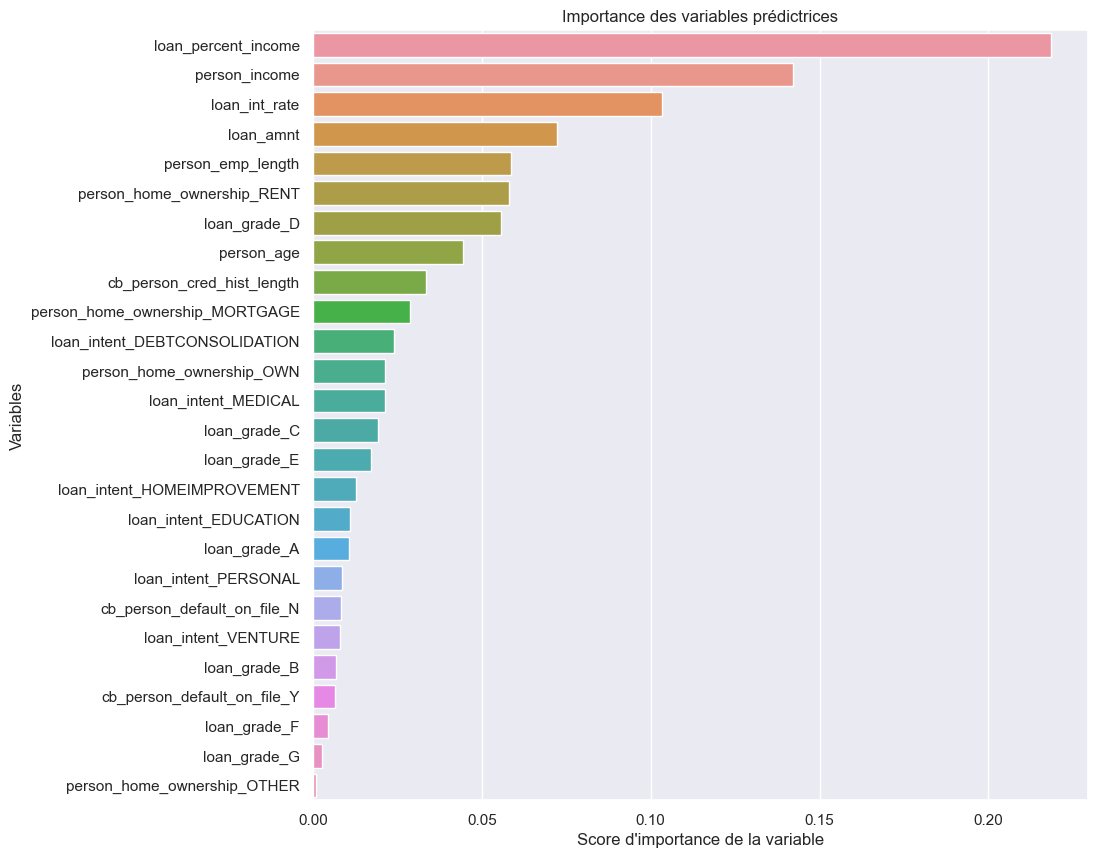

In [79]:
# Visualisation des variables importantes

sns.barplot(x=vars_imp, y=vars_imp.index) 

plt.xlabel("Score d'importance de la variable")

plt.ylabel("Variables")  

plt.title("Importance des variables prédictrices")
plt.show()


# RECONSTRUCTION D'UN MODELE DE FORETS ALEATOIRES

Remodélisons les données en ne considérant que cette fois-ci les variables dont le score d'importance est supérieur à 0,010.

In [80]:
# les variables dont le score d'importance est supérieur à 0,010( Essayez plusieurs seuils et regardez les valeurs des métriques)

vars_selected= vars_imp[vars_imp> 0.010].index.to_list()

vars_selected

['loan_percent_income',
 'person_income',
 'loan_int_rate',
 'loan_amnt',
 'person_emp_length',
 'person_home_ownership_RENT',
 'loan_grade_D',
 'person_age',
 'cb_person_cred_hist_length',
 'person_home_ownership_MORTGAGE',
 'loan_intent_DEBTCONSOLIDATION',
 'person_home_ownership_OWN',
 'loan_intent_MEDICAL',
 'loan_grade_C',
 'loan_grade_E',
 'loan_intent_HOMEIMPROVEMENT',
 'loan_intent_EDUCATION',
 'loan_grade_A']

In [81]:
# Nouvelle division des données

X_train, X_test, y_train, y_test= train_test_split(X[vars_selected], y, stratify = y, test_size = 0.3, random_state = seed)


print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(21760, 18)
(9327, 18)
(21760,)
(9327,)


In [82]:

# Création du modèle

rf2= RandomForestClassifier(random_state = seed)

# Entrainement du modèle

rf2.fit(X_train, y_train)

# Prédiction
y_pred2= rf2.predict(X_test)

# Rapport de classification

print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7290
           1       0.96      0.71      0.82      2037

    accuracy                           0.93      9327
   macro avg       0.95      0.85      0.89      9327
weighted avg       0.93      0.93      0.93      9327



En sélectionnant queles variables indépendantes dont le score d'importances est supérieur à 0.010,les performances du modèle( voir le rapport de classification ci-dessus) n'ont pas été améloiré.Cette opération nous a quand même permise de réduire la complexité du modèle car nous sommes passés de 26 à 18  variables indépendantes tout en gardant les mêmes performances qu'avec le premier modèle.

Dans ce qui suit, nous appliquerons la méthode de sous-échantillonnage afin de régler le problème de déséquilibre de classe.

# METHODE DE SOUS ECHANTILLONNAGE

Imaginons qu'on ait 100 prêts dont 20 sont en défaut de paîment et 80 ne le sont pas.La méthode de sous-échantillonnage consiste à échantillonner de facon aléatoire 20 prêts non-défauts et à les combiner avec les 20 prêts défauts de paîement pour former un ensemble de données équilibré.

In [83]:
# concaténation de X_train , y_train

df_train= pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
df_train

,loan_percent_income,person_income,loan_int_rate,loan_amnt,person_emp_length,person_home_ownership_RENT,loan_grade_D,person_age,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,loan_intent_DEBTCONSOLIDATION,person_home_ownership_OWN,loan_intent_MEDICAL,loan_grade_C,loan_grade_E,loan_intent_HOMEIMPROVEMENT,loan_intent_EDUCATION,loan_grade_A,loan_status
0,0.22,10.915016,8.32,12000,6.0,1,0,22,4,0,0,0,0,0,0,0,0,1,0
1,0.14,10.968198,13.85,8000,3.0,0,0,32,10,0,0,1,0,1,0,0,0,0,0
2,0.22,10.915016,7.88,12000,2.0,1,0,26,4,0,0,0,0,0,0,0,0,1,0
3,0.06,10.878047,7.90,3100,7.0,0,0,34,6,1,1,0,0,0,0,0,0,1,0
4,0.03,11.082143,9.62,2000,5.0,0,0,24,3,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21755,0.33,11.195471,14.09,24000,3.0,1,1,36,16,0,0,0,0,0,0,1,0,0,1
21756,0.08,11.407565,7.51,7500,1.0,0,0,27,10,0,0,1,0,0,0,0,0,1,0
21757,0.11,11.082143,13.98,7200,2.0,1,0,28,8,0,0,0,1,1,0,0,0,0,0
21758,0.04,11.184421,16.89,3000,5.0,1,1,23,4,0,1,0,0,0,0,0,0,0,1


In [84]:
# Nombre de prêts dans chaque classe

n_nondefauts, n_defauts= df_train["loan_status"].value_counts()

In [85]:
# dataframe des prêts en défaut de paîement et dataframe en non défaut de paîement

defauts_df=  df_train[df_train["loan_status"] ==1]

nondefauts_df= df_train[df_train["loan_status"] == 0]

In [86]:
# Sous-échantillonnage des non défauts pour qu'ils soient en même nombre que les défauts

nondefauts_df2= nondefauts_df.sample(n_defauts)

In [88]:
# Concaténation
df_train2= pd.concat([nondefauts_df2.reset_index(drop=True), defauts_df.reset_index(drop=True)], axis=0)

In [89]:
# Vérification du nombre de prêts dans chaque classe

df_train2["loan_status"].value_counts()

0    4752
1    4752
Name: loan_status, dtype: int64

Construisons maintenant un modèle de forêts aléatoires sur ce nouvel ensemble de données sous-échantillonné.

In [90]:
X = df_train2.drop("loan_status",axis=1) # X est une dataframe constituée uniquement des variables indépendantes de df

y= df_train2["loan_status"] # y est la variable dépendante(variable d'intérêt)

seed=23

X_train, X_test, y_train, y_test= train_test_split(X, y, stratify = y, test_size = 0.3, random_state = seed)


print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(6652, 18)
(2852, 18)
(6652,)
(2852,)


In [91]:
# Création du modèle

rf3= RandomForestClassifier(random_state = seed)

# Entrainement du modèle

rf3.fit(X_train, y_train)

# Prédiction
y_pred3= rf3.predict(X_test)

# Rapport de classification

print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1426
           1       0.92      0.78      0.85      1426

    accuracy                           0.86      2852
   macro avg       0.87      0.86      0.86      2852
weighted avg       0.87      0.86      0.86      2852



Ce rapport de classification indique que le modèle rf3 prédit les défauts de paîement de manière beaucoup plus précise que les précédents modèles.En effet, 78% des prêtsen défauts de paîement ont été correctement prédit contre 73% pour les deux modèles précédents.

# CONCLUSION

Dans ce projet nous avons traité un problème de classification.De plus, ce projet nous a permis d'ajouter plusieurs techniques utiles à notre boite à outils Machine Learning.Notre objectif était de construire un modèle qui prédit si le débiteur d'une banque sera en défaut de paîement ou pas.Un tel modèle est une véritable aide à la décision et permet aux banques de mieuxgérer le risque de crédit.

Comment rechercher les hyperparamètres optimaux d'un modèle?ce sera l'objectif principal du prochain projet.

fin